## The objective of this notebook is to follow the Modulus Project Anatomy and Workflow to solve a minumum viable example, using Modulus as a Neural Solver for Diferential Equations.

*I've written the text myself using Modulus Documentation and Resources provided by Nvidia, most codeblocks are edited versions of provided learning material and documentation, critique and feedback on content are endorsed and welcomed.*
*Most of the images used belong to Nvidia Documentation and I am not really sure how licensing works but it's out there so I took it and here is some credit and thanks a lot*

We will follow these steps to accomplish pre-training tasks and model our PiNN: Physics Informed Neural Network.

This is the recommended scalable workflow by Nvidia, the idea is to grasp how the framework expects us to face our problem and help us better use it's classes to navigate towards our solution.

Some basic note taking to be used as referenced when reading the implementations:


### 1.Hydra:
Hydra is our helper component to set our initial hyper-parameters for model building, that is, it will help us define out neural network layout, optimizer, steps, epochs,decay, loss function,solver, and logging in a standardized, replicable, and scaled way.

### 2.Geometry:
That is a keyword I really liked stumbling upon, the geometry of the problem. It is not just a data class or object, it is supposed to be an actual interpretation of the problem and it's dimensionality. The geometry is intrinsically attached to the boundaries we set for our problem, thus, our equation losses. There are pre-declared classes that help us declare the domain of our inputs.

### 3. Creating and Adding Constraints to Domain/Solver:
Modulus allow for **Sympy equations** to be converted to PyTorch equations in the back-end and can be printed for checking at any point of the training process.
Constraints and Training Objectives are alligned in physics driven problems and exactly satisfy the boundary conditions and make the PDE's residuals go to zero as fast as possible.

Example Classes: PointwiseBoundaryConstraint, PointwiseInteriorConstraint.
Loss funcions are constructed from these constraints to be optimised upon.
Criteria object is used for sub-sampling constraints, refer to docs.

The Constraint Dictionary: Nodes, Geometry, Outvar = {"Equations to solve": Desired Values }, batch_size, bounds{variable:Range_to_sampĺe_values}

### 4.Inferencer and Result Monitoring, building the Solver.
I plan to go in-depth in result monitoring later, for now basic monitoring is prrovided and a inferencer using PointwiseINferencerr class is used as a final component to build our Solver.

We extend the Solver class then run .solve(), add a main() to call our script from shell moreover running with multiple gpus using mpirun -bp <#GPU> <script_name>.py 

### 5. Solving Parameterized Problems
That's one of the most powerful features of PiNNs, it will be ilustrated and the algebra will be laid down, but as seem, the architecture incetivizes the use of arbitrary desired values, and easily comprehends parametrized intervals as such. It will be shown how our solver performs when our boundaries are the same, but the desired outcome varies between a given interval. It does not fit or solve a specific function, it learns how to respect the boundaries and produce expected behaviours for any interval in our geometry domain. 

1. Hydra config:

hydra_configs/hydra_config_PDE.yaml


```yaml
defaults :
  - modulus_default
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 200

save_filetypes : "vtk,npz"

training:
  rec_results_freq : 1000
  rec_constraint_freq: 1000
  max_steps : 5000
```

In [10]:
import modulus
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path="hydra_configs", config_name="hydra_config_PDE")
cfg.network_dir = 'outputs_checkpoints'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/home/mei/anaconda3/envs/modulus-venv/lib/python3.10/site-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 5000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: 1000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs_checkpoints
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: 

2. Geometry
For picking the geometry of the problem it's great to have in mind the role of it in the architecture, as a real problem can be interpreted in multiple different geometric representations, a casual quoting of the ref. material: 
*we will create some geometry that we can use to sample the various collocation points needed to impose the boundary and equation losses*



In [11]:
from sympy import Symbol
from modulus.sym.geometry.primitives_1d import Line1D

# make geometry
x = Symbol("x")
geo = Line1D(0, 1)


samples = geo.sample_boundary(5)
print("Boundary Samples", samples)

samples = geo.sample_interior(5)
print("Interior Samples", samples)



Boundary Samples {'x': array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]]), 'normal_x': array([[-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.]]), 'area': array([[0.33333333],
       [0.33333333],
       [0.33333333],
       [0.5       ],
       [0.5       ]])}
Interior Samples {'x': array([[0.83881577],
       [0.6928224 ],
       [0.95799151],
       [0.14222247],
       [0.08777354]]), 'sdf': array([[0.16118423],
       [0.3071776 ],
       [0.04200849],
       [0.14222247],
       [0.08777354]]), 'area': array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])}


3. Nodes

Declaring Neural Network and Equations. 
Equations use Sympy syntax, and the class modulus.sym.eq.PDE already has some pre-declared commonly used equations.

The PDE: 

In [12]:
from sympy import Symbol, Number, Function
from modulus.sym.eq.pde import PDE

class CustomPDE(PDE):
    def __init__(self, f=1.0):
        # coordinates
        x = Symbol("x")

        # make input variables
        input_variables = {"x": x}

        # make u function
        u = Function("u")(*input_variables)

        # source term
        if type(f) is str:
            f = Function(f)(*input_variables)
        elif type(f) in [float, int]:
            f = Number(f)

        # set equations
        self.equations = {}
        self.equations["custom_pde"] = (
            u.diff(x, 2) - f
        )  # "custom_pde" key name will be used in constraints
    def print_latex(self):
        return latex(self.equations["custom_pde"])

In [13]:
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.key import Key
from sympy import latex
from IPython.display import display, Math


# make list of nodes to unroll graph on
eq = CustomPDE(f=1.0)
#print latex
display(Math(eq.print_latex()))

u_net = FullyConnectedArch(
    input_keys=[Key("x")], output_keys=[Key("u")], nr_layers=3, layer_size=32
)

nodes = eq.make_nodes() + [u_net.make_node(name="u_network")]

<IPython.core.display.Math object>

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=32, bias=True)
      )
      (1-2): 2 x FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
custom_pde: u__x__x - 1.0
None
Note: you may need to restart the kernel to use updated packages.


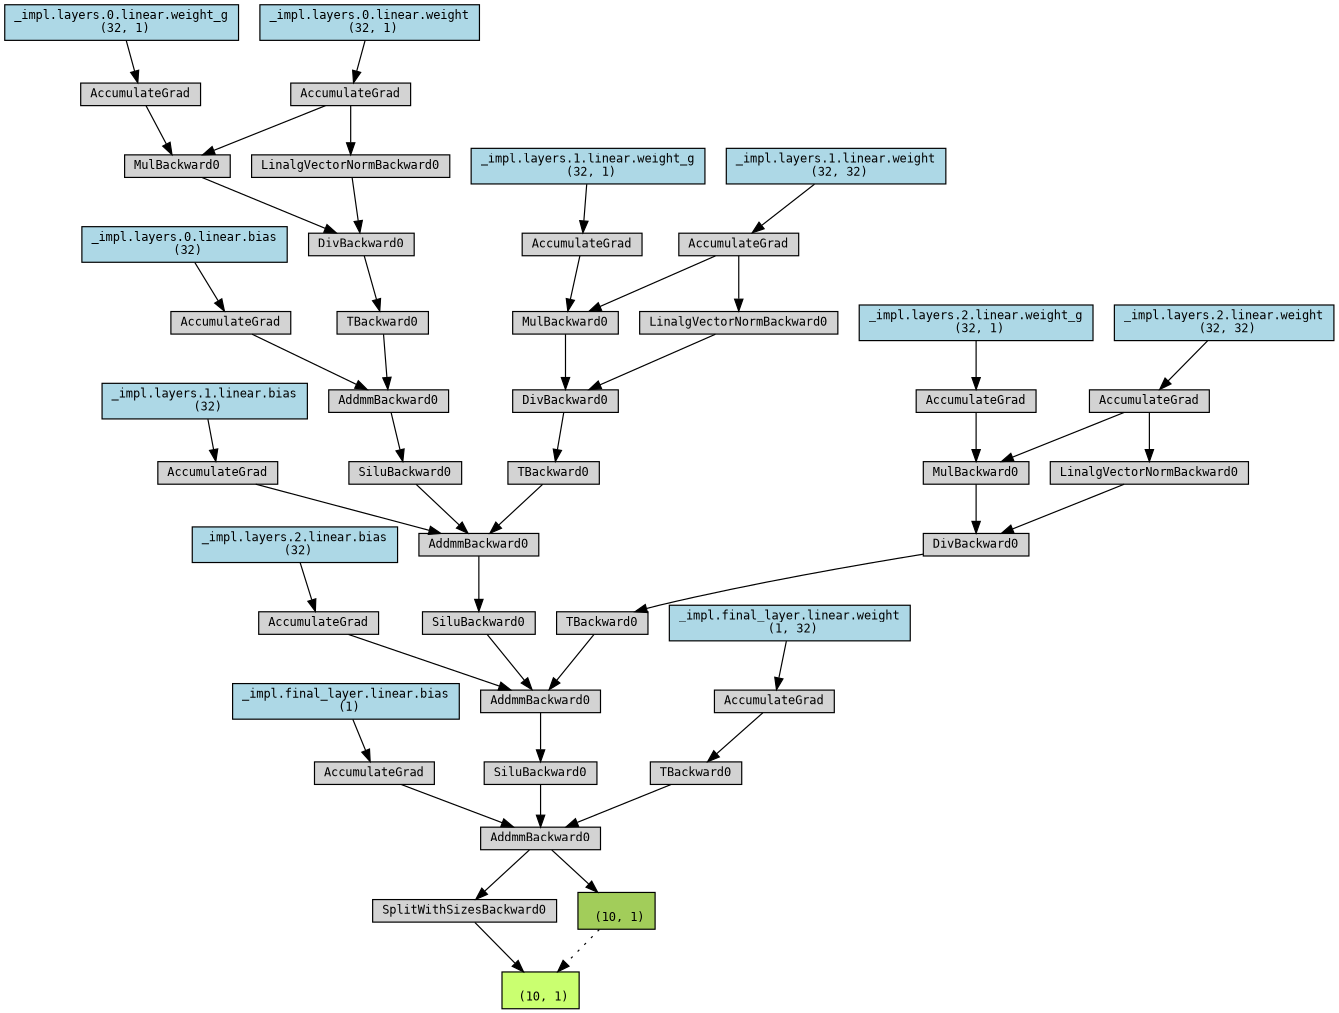

In [14]:
# visualize the network and symbolic equation in Modulus:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
%pip install torchviz
#sudo apt-get install graphviz
import torch
from torchviz import make_dot
from IPython.display import Image 
    
# pass dummy data through the model 
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=1, out_features=32, bias=True)
      )
      (1-2): 2 x FCLayer(
        (linear): WeightNormLinear(in_features=32, out_features=32, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
custom_pde: u__x__x - 1.0
None


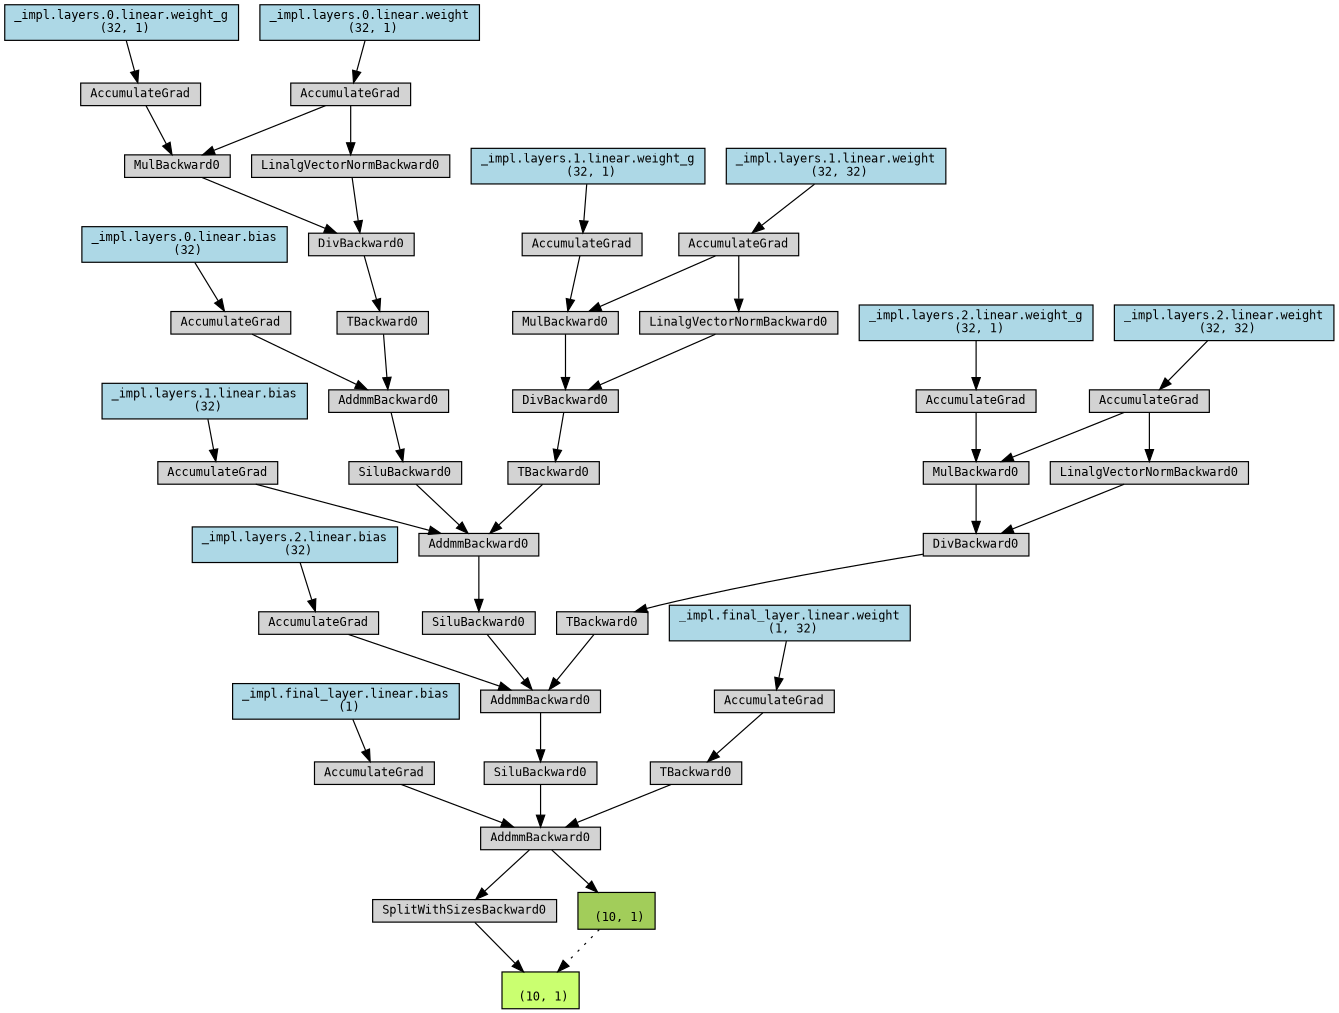

In [15]:
# visualize the network and symbolic equation in Modulus:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
#%pip install torchviz
#!sudo apt-get install graphviz
import torch
from torchviz import make_dot
from IPython.display import Image 
    
# pass dummy data through the model 
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

4. Domain

*The `Domain` holds all constraints as well as additional components needed in the training process. These additional components include inferencers, validators, and monitors. When developing in Modulus, constraints that the user defines are then added to the training `Domain` in order to create a collection of training objectives. The Domain and the configs are passed as inputs when using the `Solver` class.* 



In [16]:
from modulus.sym.domain import Domain

# make domain
domain = Domain()

We simply add constrains and residuals to the domain and Modulus will generate a L2 (standard, changeable) loss function for our network optimization.

I will directly quote this as it is critical to theory:

" **Boundary constraints:** For generating a boundary condition, we need to sample the points on the required boundary/surface of the geometry, specify the nodes we would like to unroll/evaluate on these points, and then assign them the desired values.

A boundary can be sampled using the `PointwiseBoundaryConstraint` class. This will sample the entire boundary of the geometry we specify in the geometry argument, in this case both the endpoints of the 1D line, 
[...]
the desired values for the boundary condition are listed as a dictionary in the `outvar` argument."
The number of points to sample on each boundary are specified using the `batch_size` argument.

**Equations to solve:** The Custom PDE we defined is enforced on all the points in the interior. We will use the `PointwiseInteriorConstraint` class to sample points in the interior of the geometry.
The argument `bounds`, determines the range for sampling the values for variables. "


In [17]:
from modulus.sym.domain.constraint import PointwiseBoundaryConstraint, PointwiseInteriorConstraint

# bcs
bc = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=2,
)
domain.add_constraint(bc, "bc")

# interior
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"custom_pde": 0},
    batch_size=100,
    bounds={x: (0, 1)},
)
domain.add_constraint(interior, "interior")

In [18]:
import numpy as np
from modulus.sym.domain.inferencer import PointwiseInferencer

# add inferencer
inference = PointwiseInferencer(
    nodes=nodes,
    invar={"x": np.linspace(0, 1.0, 100).reshape(-1,1)},
    output_names=["u"],
)
domain.add_inferencer(inference, "inf_data")

In [19]:
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [21]:
import os
from modulus.sym.solver import Solver

# optional set appropriate GPU in case of multi-GPU machine
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

# make solver
slv = Solver(cfg, domain)

# start solver
slv.solve()

Installed PyTorch version 2.4.0+cu121 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
/home/mei/anaconda3/envs/modulus-venv/lib/python3.10/site-packages/modulus/sym/trainer.py:453: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=enable_scaler)
attempting to restore from: /home/mei/pro/modulus/outputs_checkpoints
optimizer checkpoint not found
model u_network.0.pth not found
/home/mei/anaconda3/envs/modulus-venv/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[step:          0] saved constraint results to outputs_checkpoints
[step: 

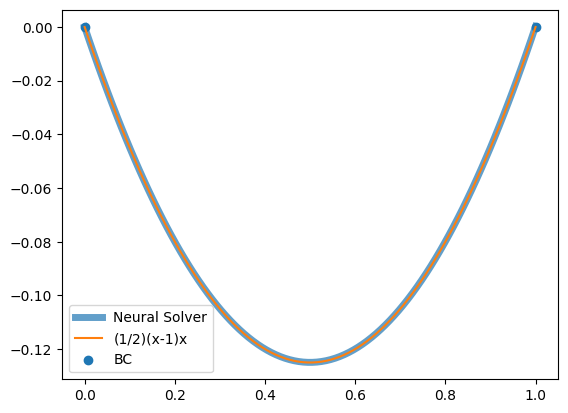

In [28]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load('./outputs_checkpoints/inferencers/inf_data.npz', allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]
plt.figure()
x = data['x'].flatten()
pred_u = data['u'].flatten()
plt.plot(np.sort(x), pred_u[np.argsort(x)], label='Neural Solver', alpha=0.7, lw=5)
plt.plot(np.sort(x), 0.5*(np.sort(x)*(np.sort(x)-1)), label='(1/2)(x-1)x')
x_np = np.array([0., 1.])
u_np = 0.5*(x_np-1)*x_np
plt.scatter(x_np, u_np, label='BC')
plt.legend()
plt.show()